In [333]:
import numpy as np
import pandas as pd

import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
import warnings
from scipy import stats
warnings.simplefilter("ignore")

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson,skellam

In [334]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

* Time to connect to OS and find our database.sqlite file

In [335]:
import os
for dirname, _, filenames in os.walk('/content/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
path = "/content/"  #Insert path here
database = path + 'database.sqlite'
conn = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

/content/database.sqlite
/content/.config/config_sentinel
/content/.config/active_config
/content/.config/.last_survey_prompt.yaml
/content/.config/.last_opt_in_prompt.yaml
/content/.config/gce
/content/.config/.last_update_check.json
/content/.config/logs/2023.05.09/13.34.35.778474.log
/content/.config/logs/2023.05.09/13.33.35.938268.log
/content/.config/logs/2023.05.09/13.34.01.584914.log
/content/.config/logs/2023.05.09/13.35.02.205775.log
/content/.config/logs/2023.05.09/13.35.02.956941.log
/content/.config/logs/2023.05.09/13.34.27.521966.log
/content/.config/configurations/config_default
/content/sample_data/README.md
/content/sample_data/anscombe.json
/content/sample_data/mnist_test.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/california_housing_train.csv
/content/sample_data/mnist_train_small.csv


,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [336]:
#all players are here with all attrib and age added
unique_players = pd.read_sql("""SELECT 					player_name, PLAYER.player_api_id as player_id,
                                        PA_Grouped.date AS date, birthday,
                                        AVG(weight) AS avg_weight,
                                        AVG(height) AS avg_height,
                                        (avg(PA_Grouped.avg_overall_rating)) AS avg_overall_rating,
                                        (avg(PA_Grouped.avg_potential)) AS avg_potential,
                                        (avg(PA_Grouped.avg_crossing)) AS avg_crossing,
                                        (avg(PA_Grouped.avg_finishing)) AS avg_finishing,
                                        (avg(PA_Grouped.avg_heading_accuracy)) AS avg_heading_accuracy,
                                        (avg(PA_Grouped.avg_short_passing)) AS avg_short_passing,
                                        (avg(PA_Grouped.avg_dribbling)) AS avg_dribbling,
                                        (avg(PA_Grouped.avg_free_kick_accuracy)) AS avg_free_kick_accuracy,
                                        (avg(PA_Grouped.avg_long_passing)) AS avg_long_passing,
                                       (avg(PA_Grouped.avg_ball_control)) AS avg_ball_control,
                                       (avg(PA_Grouped.avg_shot_power)) AS avg_shot_power,
                                       (avg(PA_Grouped.avg_stamina)) AS avg_stamina,
                                       (avg(PA_Grouped.avg_strength)) AS avg_strength,
                                       (avg(PA_Grouped.avg_positioning)) AS avg_positioning,
                                       (avg(PA_Grouped.avg_vision)) AS avg_vision,
                                       (avg(PA_Grouped.avg_penalties)) AS avg_penalties,
                                       (avg(PA_Grouped.avg_gk_reflexes)) AS avg_gk_reflexes      
                            FROM PLAYER
                            LEFT JOIN (SELECT Player_Attributes.player_api_id, 
                                        avg(Player_Attributes.overall_rating) AS avg_overall_rating,
                                        avg(Player_Attributes.potential) AS avg_potential,
                                        avg(Player_Attributes.crossing) AS avg_crossing,
                                        avg(Player_Attributes.finishing) AS avg_finishing,
                                        avg(Player_Attributes.heading_accuracy) AS avg_heading_accuracy,
                                        avg(Player_Attributes.short_passing) AS avg_short_passing,
                                        avg(Player_Attributes.dribbling) AS avg_dribbling,
                                        avg(Player_Attributes.free_kick_accuracy) AS avg_free_kick_accuracy,
                                        avg(Player_Attributes.long_passing) AS avg_long_passing,
                                       avg(Player_Attributes.ball_control) AS avg_ball_control,
                                       avg(Player_Attributes.shot_power) AS avg_shot_power,
                                       avg(Player_Attributes.stamina) AS avg_stamina,
                                       avg(Player_Attributes.strength) AS avg_strength,
                                       avg(Player_Attributes.positioning) AS avg_positioning,
                                       avg(Player_Attributes.vision) AS avg_vision,
                                       avg(Player_Attributes.penalties) AS avg_penalties,
                                       avg(Player_Attributes.gk_reflexes) AS avg_gk_reflexes,
                                       date
                                       FROM Player_Attributes
                                       GROUP BY Player_Attributes.player_api_id) 
                                       AS PA_Grouped ON PLAYER.player_api_id = PA_Grouped.player_api_id
                            GROUP BY PLAYER.player_api_id
                            ORDER BY PLAYER.player_api_id;""", conn)
unique_players[['date','birthday']] = unique_players[['date','birthday']].apply(pd.to_datetime)
unique_players['age'] = (unique_players['date'] - unique_players['birthday']).dt.days // 365
unique_players['avg_vision'].fillna(unique_players['avg_vision'].mean(), inplace = True)
unique_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   player_name             11060 non-null  object        
 1   player_id               11060 non-null  int64         
 2   date                    11060 non-null  datetime64[ns]
 3   birthday                11060 non-null  datetime64[ns]
 4   avg_weight              11060 non-null  float64       
 5   avg_height              11060 non-null  float64       
 6   avg_overall_rating      11060 non-null  float64       
 7   avg_potential           11060 non-null  float64       
 8   avg_crossing            11060 non-null  float64       
 9   avg_finishing           11060 non-null  float64       
 10  avg_heading_accuracy    11060 non-null  float64       
 11  avg_short_passing       11060 non-null  float64       
 12  avg_dribbling           11060 non-null  float6

In [337]:
# single out 2 more combinatorial features: the player's attack rating and defense rating

# offensive_score: avg_potential, avg_crossing, avg_finishing, avg_heading_accuracy, avg_short_passing, avg_dribbling, avg_free_kick_accuracy, avg_long_passing, avg_shot_power, avg_penalties
# defensive_score: avg_ball_control, avg_stamina, avg_strength, avg_positioning, avg_vision, avg_overall_rating              

unique_players["offensive_score"] = unique_players['avg_free_kick_accuracy']*0.1 + unique_players['avg_finishing']*0.1 + unique_players['avg_heading_accuracy']*0.1+unique_players['avg_crossing']*0.1+unique_players['avg_shot_power']*0.1+unique_players['avg_long_passing']*0.1 + unique_players['avg_short_passing']*0.1+unique_players['avg_dribbling']*0.1 + unique_players['avg_penalties']*0.1 + unique_players['avg_potential']*0.1
unique_players["defensive_score"] = unique_players['avg_overall_rating']*0.1 + unique_players['avg_stamina']*0.2 + unique_players['avg_ball_control']*0.2 + unique_players['avg_positioning']*0.2 + unique_players['avg_vision']*0.2 + unique_players['avg_strength']*0.1

In [338]:
def Scatterplot(data_name,x_data,y_data,plot_title,x_label,y_label):
    data_name.plot(kind = 'scatter',x = x_data,y = y_data,figsize = (10,6))
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

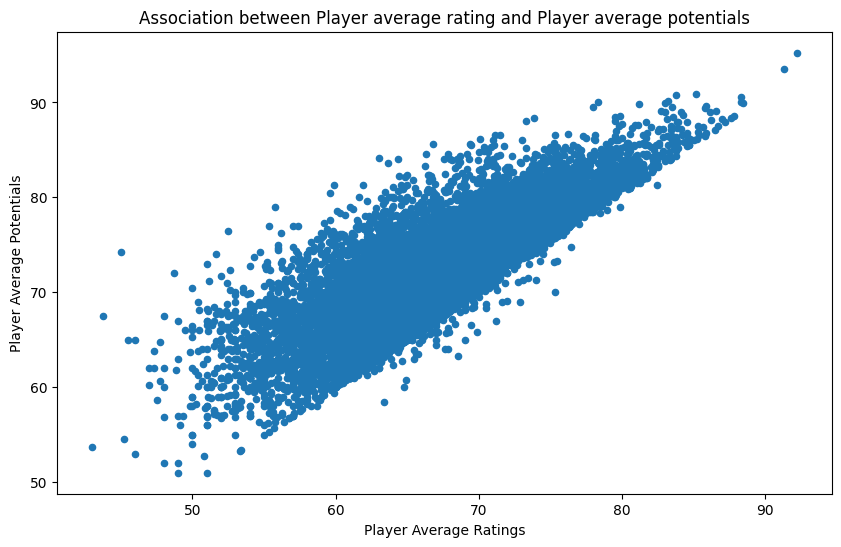

In [339]:
Scatterplot(unique_players,'avg_overall_rating','avg_potential',
           'Association between Player average rating and Player average potentials',"Player Average Ratings",
           "Player Average Potentials")

In [340]:
pearson_coef,p_value = stats.pearsonr(unique_players.avg_overall_rating,unique_players.avg_potential)
print(f'The Pearson Correlation coefficient is {pearson_coef}, and the pvalue is {p_value}')

The Pearson Correlation coefficient is 0.8094094038917423, and the pvalue is 0.0


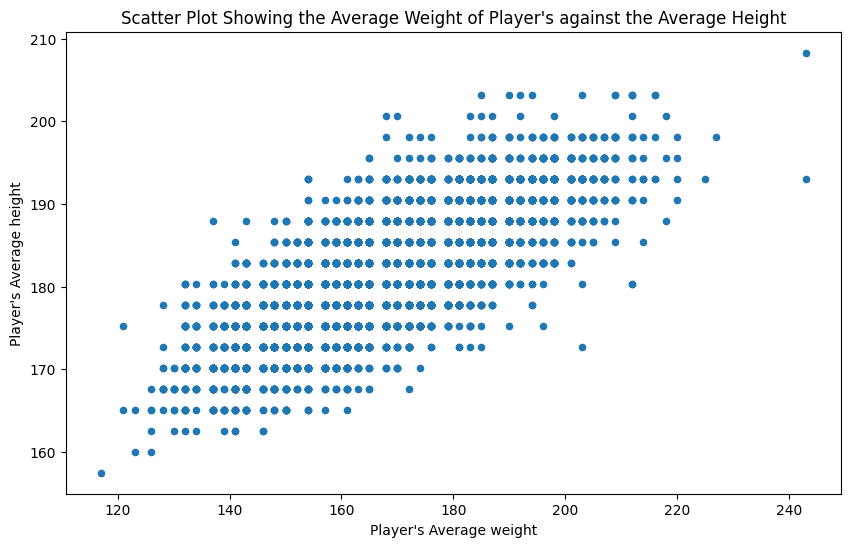

In [341]:
Scatterplot(unique_players,'avg_weight','avg_height',
            "Scatter Plot Showing the Average Weight of Player's against the Average Height",
            "Player's Average weight",
           "Player's Average height")

In [342]:
pearson_coef,p_value = stats.pearsonr(unique_players.avg_weight,unique_players.avg_height)
print(f'The Pearson Correlation coefficient is {pearson_coef}, and the pvalue is {p_value}')

The Pearson Correlation coefficient is 0.7666258504097696, and the pvalue is 0.0


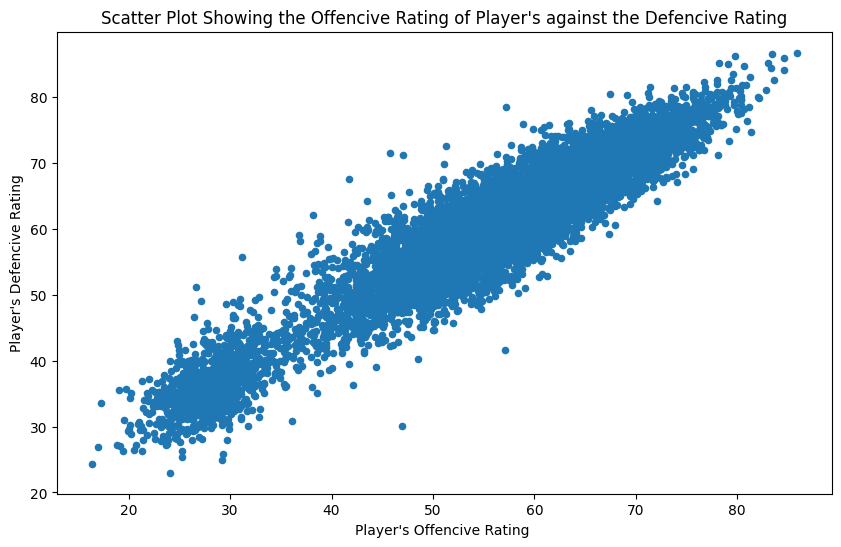

In [343]:
Scatterplot(unique_players,'offensive_score','defensive_score',
            "Scatter Plot Showing the Offencive Rating of Player's against the Defencive Rating",
            "Player's Offencive Rating ",
           "Player's Defencive Rating")

In [344]:
pearson_coef,p_value = stats.pearsonr(unique_players.offensive_score,unique_players.defensive_score)
print(f'The Pearson Correlation coefficient is {pearson_coef}, and the pvalue is {p_value}')

The Pearson Correlation coefficient is 0.939643515925111, and the pvalue is 0.0


In [345]:
#team winning percentage relative to all games

best_teams = pd.read_sql("""WITH 
                        temp AS (

                            SELECT m.match_api_id, 
                                ht.team_long_name AS  home_team,
                                AT.team_long_name AS away_team,
                                home_team_goal, 
                                away_team_goal,
                                ht.team_api_id AS h_id,
                                at.team_api_id AS a_id,
                            CASE 
                                when m.home_team_goal > m.away_team_goal then ht.team_api_id
                                when m.home_team_goal < m.away_team_goal then at.team_api_id else 'Draw' end as winner
                            FROM Match AS m
                            LEFT JOIN Team AS ht on ht.team_api_id = m.home_team_api_id
                            LEFT JOIN Team AS at on at.team_api_id = m.away_team_api_id
                        ),
                        home AS (
                            SELECT COUNT(match_api_id) AS home_games,
                                home_team AS team_name,
                                h_id
                            FROM temp
                            GROUP BY home_team 
                        ),
                        away AS (
                            SELECT COUNT(match_api_id) AS away_games,
                                away_team AS team_name,
                                a_id
                            FROM temp
                            GROUP BY away_team
                        ),
                        total AS (
                            SELECT a.away_games + h.home_games AS total_games,
                            h.team_name,
                            h.h_id
                            FROM home AS h 
                            JOIN away AS a ON h.h_id = a.a_id
                            GROUP BY h.team_name
                        ),
                        wins AS (
                            SELECT winner, COUNT(*) AS wins
                            FROM temp
                            GROUP BY winner 
                        )
                        
                        SELECT t.total_games,
                            t.team_name,
                            w.wins,
                            (w.wins)*100/(t.total_games) AS win_percentage
                        FROM total AS t
                        JOIN wins AS w on t.h_id = w.winner
                        ORDER BY wins DESC;""", conn)
best_teams.head(5)

,total_games,team_name,wins,win_percentage
0,304,FC Barcelona,234,76
1,304,Real Madrid CF,228,75
2,304,Celtic,218,71
3,272,FC Bayern Munich,193,70
4,304,Manchester United,192,63


In [346]:
best_players = pd.read_sql("""SELECT pa.player_api_id , p.player_name , pa.overall_rating
                FROM Player_Attributes as pa
                INNER JOIN Player as p
                ON pa.player_api_id = p.player_api_id 
                GROUP BY pa.player_api_id
                ORDER BY pa.overall_rating DESC;""", conn)
best_players.head(5)

,player_api_id,player_name,overall_rating
0,30981,Lionel Messi,94
1,30893,Cristiano Ronaldo,93
2,40636,Luis Suarez,90
3,27299,Manuel Neuer,90
4,19533,Neymar,90


In [347]:
#group by away/home goals scored, or by general indicators. Just a cut of the data

away_perf = pd.read_sql_query("""with home as (
	select 
		home_team_api_id, t.team_long_name || ' (' || c.name || ')' as Team_name,
		sum(m.home_team_goal) as home_Goal
	from match as m
		left join Country as c
		on m.country_id = c.id
		left join team as t
		on t.team_api_id = m.home_team_api_id
	group by Team_name),
away as (
	select
		away_team_api_id, t.team_long_name || ' (' || c.name || ')' as Team_name,
		sum(m.away_team_goal) as away_Goal
	from match as m
		left join Country as c
		on m.country_id = c.id
    left join team as t
		on t.team_api_id = m.away_team_api_id
	group by Team_name)
select 
	home_team_api_id as team_api_id,
	home.team_name as team_name,
	away.away_goal,
	home.home_goal,
	(away.away_goal + home.home_goal) as total_goal
    from away 
	left join home 
	on home.team_name = away.team_name
    group by home.team_name
    order by total_goal desc;""", conn)

away_perf

,team_api_id,team_name,away_Goal,home_Goal,total_goal
0,8634,FC Barcelona (Spain),354,495,849
1,8633,Real Madrid CF (Spain),338,505,843
2,9925,Celtic (Scotland),306,389,695
3,9823,FC Bayern Munich (Germany),271,382,653
4,8640,PSV (Netherlands),282,370,652
...,...,...,...,...,...
291,10213,Amadora (Portugal),10,16,26
292,7992,Trofense (Portugal),11,14,25
293,6631,FC Dordrecht (Netherlands),9,15,24
294,7869,Córdoba CF (Spain),10,12,22


In [348]:
#for a script that collects player attributes into team data via away_player_2, away_player_3, away_player_4.. this table is a duplicate of allmatches, but without any NAN

allmatches1 = pd.read_sql_query ("""SELECT match_api_id, l.name AS league, Country.name AS country, season, Match.date, B365H, B365D, B365A, stage, (CASE 
                                when Match.home_team_goal > Match.away_team_goal then Team.team_long_name
                                when Match.home_team_goal < Match.away_team_goal then OpponentTeam.team_long_name else 'Draw' end)winner, Team.team_long_name As home_team,
Team.team_short_name as home_team_short,
away_player_1, away_player_2, away_player_3, away_player_4,
away_player_5, away_player_6, away_player_7, away_player_8, away_player_9,
away_player_10, away_player_11,home_player_1, home_player_2, home_player_3, home_player_4, home_player_5,
home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11,
match.home_team_api_id as h_api_id,
match.home_team_goal as home_goal,
(CASE
WHEN home_team_goal = away_team_goal THEN 1
WHEN home_team_goal > away_team_goal THEN 3
WHEN home_team_goal < away_team_goal THEN 0
END)home_Points,
OpponentTeam.team_long_name AS away_team,
OpponentTeam.team_short_name AS away_team_short,
match.away_team_api_id as a_api_id,
match.away_team_goal as away_goal,
(CASE
WHEN home_team_goal = away_team_goal THEN 1
WHEN home_team_goal < away_team_goal THEN 3
WHEN home_team_goal > away_team_goal THEN 0
END)away_Points,
home_team_goal-away_team_goal AS goal_dif,
home_team_goal+away_team_goal AS match_goals 
FROM match 
JOIN Country ON match.country_id = Country.id
JOIN League AS l on match.league_id = l.id
JOIN Team ON match.home_team_api_id = Team.team_api_id 
JOIN Team AS OpponentTeam ON match.away_team_api_id = OpponentTeam.team_api_id
JOIN Team_Attributes AS htr ON htr.team_api_id = match.home_team_api_id
JOIN Team_Attributes AS atr ON atr.team_api_id = match.away_team_api_id
GROUP BY match_api_id;""", conn)
allmatches1.dropna(inplace=True)
allmatches1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19609 entries, 1 to 25627
Data columns (total 44 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   match_api_id     19609 non-null  int64  
 1   league           19609 non-null  object 
 2   country          19609 non-null  object 
 3   season           19609 non-null  object 
 4   date             19609 non-null  object 
 5   B365H            19609 non-null  float64
 6   B365D            19609 non-null  float64
 7   B365A            19609 non-null  float64
 8   stage            19609 non-null  int64  
 9   winner           19609 non-null  object 
 10  home_team        19609 non-null  object 
 11  home_team_short  19609 non-null  object 
 12  away_player_1    19609 non-null  float64
 13  away_player_2    19609 non-null  float64
 14  away_player_3    19609 non-null  float64
 15  away_player_4    19609 non-null  float64
 16  away_player_5    19609 non-null  float64
 17  away_player_

In [349]:
allmatches = pd.read_sql_query ("""SELECT match_api_id, l.name AS league, l.id as league_id, Country.name AS country, season, Match.date, B365H, B365D, B365A, stage, (CASE 
                                when Match.home_team_goal > Match.away_team_goal then Team.team_long_name
                                when Match.home_team_goal < Match.away_team_goal then OpponentTeam.team_long_name else 'Draw' end)winner, Team.team_long_name As home_team,
Team.team_short_name as home_team_short,
match.home_team_api_id as h_api_id,
match.home_team_goal as home_goal,
(CASE
WHEN home_team_goal = away_team_goal THEN 1
WHEN home_team_goal > away_team_goal THEN 3
WHEN home_team_goal < away_team_goal THEN 0
END)home_Points,
OpponentTeam.team_long_name AS away_team,
OpponentTeam.team_short_name AS away_team_short,
match.away_team_api_id as a_api_id,
match.away_team_goal as away_goal,
(CASE
WHEN home_team_goal = away_team_goal THEN 1
WHEN home_team_goal < away_team_goal THEN 3
WHEN home_team_goal > away_team_goal THEN 0
END)away_Points,
home_team_goal-away_team_goal AS goal_dif,
home_team_goal+away_team_goal AS match_goals 
FROM match 
JOIN Country ON match.country_id = Country.id
JOIN League AS l on match.league_id = l.id
JOIN Team ON match.home_team_api_id = Team.team_api_id 
JOIN Team AS OpponentTeam ON match.away_team_api_id = OpponentTeam.team_api_id
JOIN Team_Attributes AS htr ON htr.team_api_id = match.home_team_api_id
JOIN Team_Attributes AS atr ON atr.team_api_id = match.away_team_api_id
GROUP BY match_api_id;""", conn)
# allmatches.dropna(inplace=True) 

# define a function for result: win -> 1, lost -> -1, draw -> 0
def this_map(x):
    if x < 0:
        return -1
    if x > 0:
        return 1
    return 0
allmatches['result'] = allmatches['home_goal'] - allmatches['away_goal']
allmatches['result'] = allmatches['result'].apply(lambda x:this_map(x))

allmatches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25629 entries, 0 to 25628
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   match_api_id     25629 non-null  int64  
 1   league           25629 non-null  object 
 2   league_id        25629 non-null  int64  
 3   country          25629 non-null  object 
 4   season           25629 non-null  object 
 5   date             25629 non-null  object 
 6   B365H            22309 non-null  float64
 7   B365D            22309 non-null  float64
 8   B365A            22309 non-null  float64
 9   stage            25629 non-null  int64  
 10  winner           25629 non-null  object 
 11  home_team        25629 non-null  object 
 12  home_team_short  25629 non-null  object 
 13  h_api_id         25629 non-null  int64  
 14  home_goal        25629 non-null  int64  
 15  home_Points      25629 non-null  int64  
 16  away_team        25629 non-null  object 
 17  away_team_sh

In [350]:
# this is the scaled data for model simulation (GROUPED BY api_home + api_away team)

matches = pd.read_sql("""SELECT match_api_id, l.name AS league, B365H, B365D, B365A, Country.name AS country, season, 
(CASE when Match.home_team_goal > Match.away_team_goal then Team.team_long_name
when Match.home_team_goal < Match.away_team_goal then OpponentTeam.team_long_name else 'Draw' end)winner, 
                                Team.team_long_name As home_team,
                                match.home_team_api_id as h_api_id,
                                ROUND(avg(htr.buildUpPlayPassing),2) as h_avg_PlayPassing,
                                ROUND(avg(htr.buildUpPlaySpeed),2) as h_avg_PlaySpeed,
                                ROUND(avg(htr.chanceCreationPassing),2) as h_avg_CreationPassing,
                                ROUND(avg(htr.defencepressure),2) as h_avg_defencePressure,
                                ROUND(avg(htr.defenceteamwidth),2) as h_avg_defenceTeamWidth,
                                ROUND(avg(match.home_team_goal),2) AS Avg_goals_HOME,
                                match.home_team_goal as home_goal,
(CASE
WHEN home_team_goal = away_team_goal THEN 1
WHEN home_team_goal > away_team_goal THEN 3
WHEN home_team_goal < away_team_goal THEN 0
END)home_Points,

                                OpponentTeam.team_long_name AS away_team,
                                match.away_team_api_id as a_api_id,
                                ROUND(avg(atr.buildUpPlayPassing),2) as a_avg_PlayPassing,
                                ROUND(avg(atr.buildUpPlaySpeed),2) as a_avg_PlaySpeed,
                                ROUND(avg(atr.chanceCreationPassing),2) as a_avg_CreationPassing,
                                ROUND(avg(atr.defencepressure),2) as a_avg_defencePressure,
                                ROUND(avg(atr.defenceteamwidth),2) as a_avg_defenceTeamWidth,
                                ROUND(avg(match.away_team_goal),2) AS Avg_goals_AWAY,
                                match.away_team_goal as away_goal,
(CASE
WHEN home_team_goal = away_team_goal THEN 1
WHEN home_team_goal < away_team_goal THEN 3
WHEN home_team_goal > away_team_goal THEN 0
END)away_Points,
                                home_team_goal-away_team_goal AS goal_dif,
                                sum(home_team_goal+away_team_goal) AS total_goals 
FROM match 
JOIN Country ON match.country_id = Country.id
JOIN League AS l on match.league_id = l.id
JOIN Team ON match.home_team_api_id = Team.team_api_id 
JOIN Team AS OpponentTeam ON match.away_team_api_id = OpponentTeam.team_api_id
JOIN Team_Attributes AS htr ON htr.team_api_id = match.home_team_api_id
JOIN Team_Attributes AS atr ON atr.team_api_id = match.away_team_api_id
GROUP BY h_api_id, a_api_id
ORDER BY h_api_id, a_api_id""", conn)
matches.dropna(inplace=True)
matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6031 entries, 22 to 6684
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   match_api_id            6031 non-null   int64  
 1   league                  6031 non-null   object 
 2   B365H                   6031 non-null   float64
 3   B365D                   6031 non-null   float64
 4   B365A                   6031 non-null   float64
 5   country                 6031 non-null   object 
 6   season                  6031 non-null   object 
 7   winner                  6031 non-null   object 
 8   home_team               6031 non-null   object 
 9   h_api_id                6031 non-null   int64  
 10  h_avg_PlayPassing       6031 non-null   float64
 11  h_avg_PlaySpeed         6031 non-null   float64
 12  h_avg_CreationPassing   6031 non-null   float64
 13  h_avg_defencePressure   6031 non-null   float64
 14  h_avg_defenceTeamWidth  6031 non-null  

In [351]:
#aggregation team points for Classification models

team_points = pd.read_sql("""SELECT
                                        l.name AS league,                                        
                                        t.team_long_name as team_name,
                                        t.team_api_id as team_api_id,
                                        sum(CASE
                                        WHEN home_team_goal = away_team_goal THEN 1
                                        WHEN home_team_goal > away_team_goal THEN 3
                                        WHEN home_team_goal < away_team_goal THEN 0
                                        END)home_Points,
                                        sum(CASE
                                        WHEN home_team_goal = away_team_goal THEN 1
                                        WHEN home_team_goal < away_team_goal THEN 3
                                        WHEN home_team_goal > away_team_goal THEN 0
                                        END)away_Points                                     
                                FROM Match m
                                JOIN Country c on c.id = m.country_id
                                JOIN League l on l.id = m.league_id
                                LEFT JOIN Team AS t on t.team_api_id = m.home_team_api_id   
                                GROUP BY  t.team_long_name
                                ORDER BY  t.team_long_name;""", conn)
team_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   league       296 non-null    object
 1   team_name    296 non-null    object
 2   team_api_id  296 non-null    int64 
 3   home_Points  296 non-null    int64 
 4   away_Points  296 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 11.7+ KB


In [352]:
#agregation of game statistics by leagues (88 lines) and seasons

leag = pd.read_sql("""SELECT 									
                                        Country.name AS country, 
                                        League.name AS league, 
                                        ht.team_long_name AS team_name,
                                        ht.team_api_id as team_api_id,
                                        sum(CASE
when Match.home_team_goal = Match.away_team_goal THEN 1
WHEN Match.home_team_goal > Match.away_team_goal THEN 3
WHEN Match.home_team_goal < Match.away_team_goal THEN 0
END)home_Points,
sum(CASE
WHEN Match.home_team_goal = Match.away_team_goal THEN 1
WHEN Match.home_team_goal < Match.away_team_goal THEN 3
WHEN Match.home_team_goal > Match.away_team_goal THEN 0
END)away_Points, 
                                        season,
                                        count(distinct stage) AS number_of_stages,
                                        count(distinct HT.team_long_name) AS number_of_teams,
                                        avg(home_team_goal) AS avg_home_team_goals, 
                                        avg(away_team_goal) AS avg_away_team_goals, 
                                        avg(home_team_goal-away_team_goal) AS avg_goal_dif, 
                                        avg(home_team_goal+away_team_goal) AS avg_total_goals,                  
                                        sum(home_team_goal+away_team_goal) AS total_goals           
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                GROUP BY League.name, season
                                ORDER BY League.name, season DESC;""", conn)
leag['total_points'] = leag['home_Points']+ leag['away_Points']
leag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              88 non-null     object 
 1   league               88 non-null     object 
 2   team_name            88 non-null     object 
 3   team_api_id          88 non-null     int64  
 4   home_Points          88 non-null     int64  
 5   away_Points          88 non-null     int64  
 6   season               88 non-null     object 
 7   number_of_stages     88 non-null     int64  
 8   number_of_teams      88 non-null     int64  
 9   avg_home_team_goals  88 non-null     float64
 10  avg_away_team_goals  88 non-null     float64
 11  avg_goal_dif         88 non-null     float64
 12  avg_total_goals      88 non-null     float64
 13  total_goals          88 non-null     int64  
 14  total_points         88 non-null     int64  
dtypes: float64(4), int64(7), object(4)
memory 

In [353]:
#team's attributes - can be viewed in terms of correlation

team_attrib = pd.read_sql("""SELECT 	
			Team.team_long_name as team_name, 
			Team.team_short_name as team_name_short,
  		Team_Attributes.team_api_id,
  		avg(Team_Attributes.buildUpPlaySpeed) as avg_PlaySpeed, 
  		avg(Team_Attributes.buildUpPlayPassing) as avg_PlayPassing,
  		avg(Team_Attributes.buildupplaydribbling) as avg_PlayDribbling,
  		avg(Team_Attributes.chanceCreationPassing) as avg_CreationPassing,
  		avg(Team_Attributes.chanceCreationCrossing) as avg_CreationCrossing,
  		avg(Team_Attributes.chancecreationshooting) as avg_CreationShooting,
  		avg(Team_Attributes.defencepressure) as avg_defencePressure,
  		avg(Team_Attributes.defenceaggression) as avg_defenceAgression,
  		avg(Team_Attributes.defenceteamwidth) as avg_defenceTeamWidth,
      COUNT(Team_Attributes.team_api_id) as seasons_played
FROM Team_Attributes
JOIN Team
ON Team_Attributes.team_api_id = Team.team_api_id
GROUP BY Team_Attributes.team_api_id;""", conn)

team_attrib.fillna(team_attrib['avg_PlayDribbling'].mean(), inplace=True)
team_attrib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   team_name             288 non-null    object 
 1   team_name_short       288 non-null    object 
 2   team_api_id           288 non-null    int64  
 3   avg_PlaySpeed         288 non-null    float64
 4   avg_PlayPassing       288 non-null    float64
 5   avg_PlayDribbling     288 non-null    float64
 6   avg_CreationPassing   288 non-null    float64
 7   avg_CreationCrossing  288 non-null    float64
 8   avg_CreationShooting  288 non-null    float64
 9   avg_defencePressure   288 non-null    float64
 10  avg_defenceAgression  288 non-null    float64
 11  avg_defenceTeamWidth  288 non-null    float64
 12  seasons_played        288 non-null    int64  
dtypes: float64(9), int64(2), object(2)
memory usage: 29.4+ KB


In [354]:
#adding data on the effectiveness of these commands to the attribute table of commands

#or define a function for result: win -> 1, lost -> -1, draw -> 0

team_results = pd.read_sql("""
SELECT Match.home_team_api_id AS homeTeam,
     
       (CASE
            WHEN home_team_goal = away_team_goal THEN 'loss'
            WHEN home_team_goal > away_team_goal THEN 'win'
            WHEN home_team_goal < away_team_goal THEN 'draw'
        END)result1,
       Match.away_team_api_id AS awayTeam,

       (CASE
            WHEN home_team_goal = away_team_goal THEN 'loss'
            WHEN home_team_goal > away_team_goal THEN 'draw'
            WHEN home_team_goal < away_team_goal THEN 'win'
        END)result2
FROM  MATCH
LEFT JOIN Team AS home ON home.team_api_id = Match.home_team_api_id
LEFT JOIN Team AS away ON away.team_api_id = Match.away_team_api_id
;""", conn)

In [355]:
team_results1=team_results[['homeTeam','result1']]
team_results2=team_results[['awayTeam','result2']]

In [356]:
team_results=pd.DataFrame(np.concatenate((team_results1.values,team_results2.values),axis =0))
team_results.columns=['Team','wins']
team_results = team_results[team_results['wins']== 'win']
team_results=team_results.groupby('Team')['wins'].count().reset_index()

team_attrib = pd.merge(team_results,team_attrib,left_on='Team',right_on='team_api_id')
team_attrib.head(5)

,Team,wins,team_name,team_name_short,team_api_id,avg_PlaySpeed,avg_PlayPassing,avg_PlayDribbling,avg_CreationPassing,avg_CreationCrossing,avg_CreationShooting,avg_defencePressure,avg_defenceAgression,avg_defenceTeamWidth,seasons_played
0,1601,92,Ruch Chorzów,CHO,1601,47.333333,46.166667,48.0,55.500000,60.333333,53.5,47.166667,47.333333,49.333333,6
1,1773,22,Oud-Heverlee Leuven,O-H,1773,52.000000,50.000000,51.0,50.000000,53.000000,54.0,43.000000,44.000000,50.000000,3
2,1957,87,Jagiellonia Białystok,BIA,1957,47.166667,52.666667,54.0,50.833333,36.333333,67.0,49.333333,56.333333,53.666667,6
3,2033,32,S.C. Olhanense,OLH,2033,49.000000,48.400000,62.0,51.800000,44.200000,48.2,42.200000,33.800000,45.400000,5
4,2182,124,Lech Poznań,POZ,2182,60.333333,49.000000,52.5,56.666667,57.333333,68.0,51.666667,48.500000,54.500000,6


<Axes: xlabel='name', ylabel='WINS'>

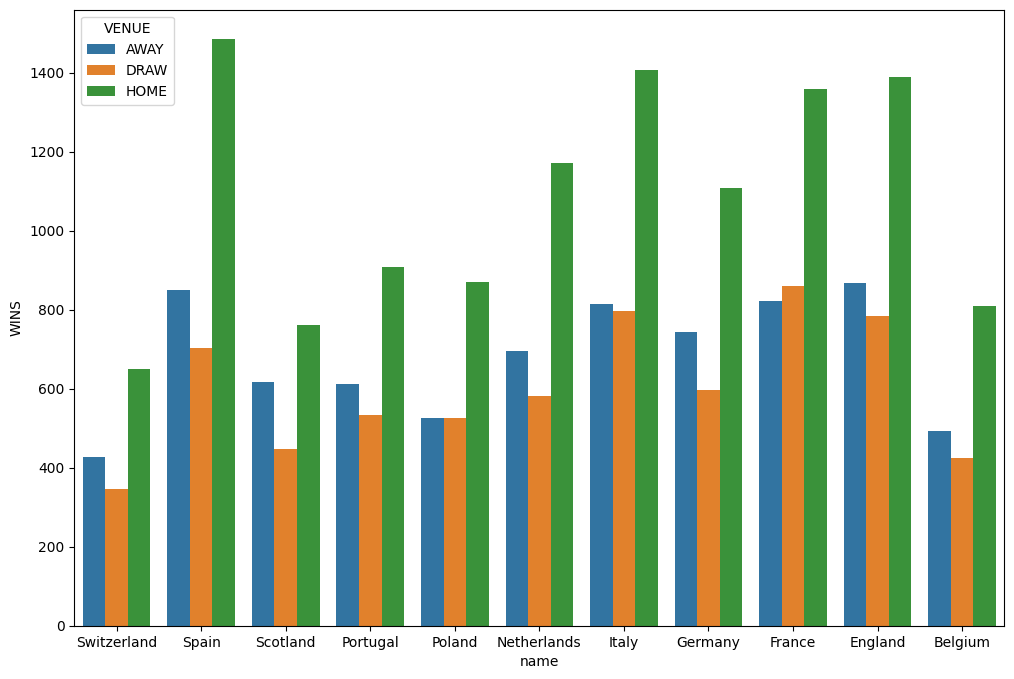

In [357]:
# is it true that teams perform better on home ground???

away_home_win = pd.read_sql_query("SELECT \
                        c.name,\
                        case when m.home_team_goal > m.away_team_goal Then 'HOME'\
                        when m.home_team_goal < m.away_team_goal Then 'AWAY'\
                        else 'DRAW' end as VENUE,\
                        count(*) as WINS\
                    FROM\
                        Match as m\
                        join Country as c\
                        on c.id = m.country_id\
                    group by c.name, VENUE\
                    order by c.name desc;""", conn)

plt.figure(figsize = (12,8))
sns.barplot(x = 'name', y = 'WINS', data = away_home_win, hue = 'VENUE' )

In [358]:
team_attrib.corr()

,Team,wins,team_api_id,avg_PlaySpeed,avg_PlayPassing,avg_PlayDribbling,avg_CreationPassing,avg_CreationCrossing,avg_CreationShooting,avg_defencePressure,avg_defenceAgression,avg_defenceTeamWidth,seasons_played
Team,1.000000,-0.104901,1.000000,0.040839,-0.015792,0.038529,0.020196,-0.093966,-0.108857,-0.103537,-0.072639,-0.129571,-0.196105
wins,-0.104901,1.000000,-0.104901,0.051135,-0.285892,0.073135,0.176269,0.126610,0.157033,0.281544,0.139173,0.105819,0.499547
team_api_id,1.000000,-0.104901,1.000000,0.040839,-0.015792,0.038529,0.020196,-0.093966,-0.108857,-0.103537,-0.072639,-0.129571,-0.196105
avg_PlaySpeed,0.040839,0.051135,0.040839,1.000000,0.426408,0.048661,0.372923,0.221423,-0.008652,-0.049331,0.155607,0.049785,0.185601
avg_PlayPassing,-0.015792,-0.285892,-0.015792,0.426408,1.000000,-0.177060,0.202898,0.254680,-0.163041,-0.133007,0.154895,0.030190,-0.105221
avg_PlayDribbling,0.038529,0.073135,0.038529,0.048661,-0.177060,1.000000,0.094599,-0.012291,0.108608,-0.010042,-0.056103,0.051731,0.026502
avg_CreationPassing,0.020196,0.176269,0.020196,0.372923,0.202898,0.094599,1.000000,0.321127,0.098816,0.172795,0.122559,0.135042,0.218881
avg_CreationCrossing,-0.093966,0.126610,-0.093966,0.221423,0.254680,-0.012291,0.321127,1.000000,-0.048644,0.046529,0.018051,0.123309,0.144287
avg_CreationShooting,-0.108857,0.157033,-0.108857,-0.008652,-0.163041,0.108608,0.098816,-0.048644,1.000000,0.228046,0.133461,0.178149,0.044469
avg_defencePressure,-0.103537,0.281544,-0.103537,-0.049331,-0.133007,-0.010042,0.172795,0.046529,0.228046,1.000000,0.436239,0.564388,0.092346


In [359]:
team_attrib.corr()['wins']

Team                   -0.104901
wins                    1.000000
team_api_id            -0.104901
avg_PlaySpeed           0.051135
avg_PlayPassing        -0.285892
avg_PlayDribbling       0.073135
avg_CreationPassing     0.176269
avg_CreationCrossing    0.126610
avg_CreationShooting    0.157033
avg_defencePressure     0.281544
avg_defenceAgression    0.139173
avg_defenceTeamWidth    0.105819
seasons_played          0.499547
Name: wins, dtype: float64

<Axes: >

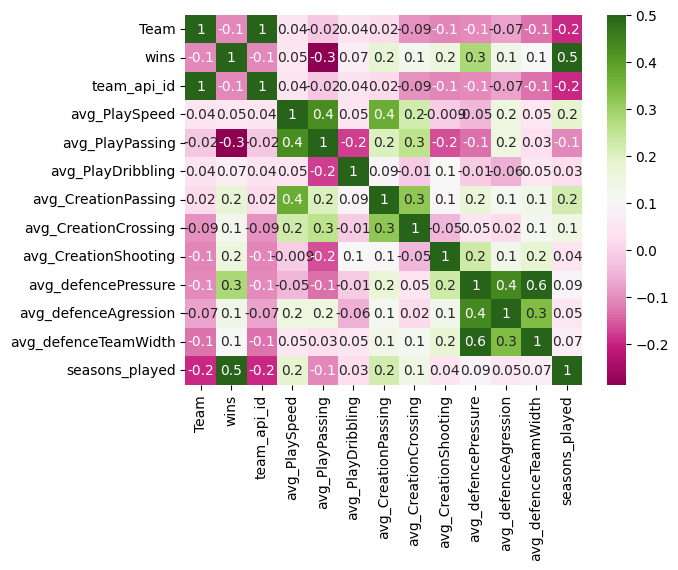

In [360]:
sns.heatmap(team_attrib.corr(), annot = True, fmt='.1g', cmap= 'PiYG', vmax=0.5)
#нужные нам признаки: #avg_PlayPassing #avg_PlaySpeed #avg_CreationPassing #avg_defencePressure #avg_defenceTeamWidth #seasons_played



---



* **Match entropy research:** 

In [361]:
from scipy.stats import entropy
def match_entropy(row):
    odds = [row['B365H'],row['B365D'],row['B365A']]
    #change odds to probability
    probs = [1/o for o in odds]
    #normalize to sum to 1
    norm = sum(probs)
    probs = [p/norm for p in probs]
    return entropy(probs)
allmatches['entropy'] = allmatches.apply(match_entropy,axis=1)

In [362]:
allmatches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25629 entries, 0 to 25628
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   match_api_id     25629 non-null  int64  
 1   league           25629 non-null  object 
 2   league_id        25629 non-null  int64  
 3   country          25629 non-null  object 
 4   season           25629 non-null  object 
 5   date             25629 non-null  object 
 6   B365H            22309 non-null  float64
 7   B365D            22309 non-null  float64
 8   B365A            22309 non-null  float64
 9   stage            25629 non-null  int64  
 10  winner           25629 non-null  object 
 11  home_team        25629 non-null  object 
 12  home_team_short  25629 non-null  object 
 13  h_api_id         25629 non-null  int64  
 14  home_goal        25629 non-null  int64  
 15  home_Points      25629 non-null  int64  
 16  away_team        25629 non-null  object 
 17  away_team_sh

In [363]:
entropy_means = allmatches.groupby(['season','league']).entropy.mean()
entropy_means = entropy_means.reset_index().pivot(index='season', columns='league', values='entropy')
entropy_means.head(10)

league,Belgium Jupiler League,England Premier League,France Ligue 1,Germany 1. Bundesliga,Italy Serie A,Netherlands Eredivisie,Poland Ekstraklasa,Portugal Liga ZON Sagres,Scotland Premier League,Spain LIGA BBVA,Switzerland Super League
season,,,,,,,,,,,
2008/2009,1.003079,0.984556,1.026638,1.004276,1.002201,0.982937,NaN,1.004361,0.989919,1.010859,NaN
2009/2010,1.002933,0.956496,1.013821,0.997925,1.006755,0.953904,NaN,0.983286,0.991430,0.977810,NaN
2010/2011,1.001498,0.983258,1.026236,1.016264,1.006029,0.948478,NaN,0.988239,0.981203,0.975032,NaN
2011/2012,0.993622,0.969593,1.024915,1.001298,1.003077,0.927274,NaN,0.968005,0.992080,0.955339,NaN
2012/2013,1.000187,0.981472,1.016116,0.993993,1.003565,0.950659,NaN,0.975749,1.020779,0.970580,NaN
2013/2014,NaN,0.960473,1.004439,0.977500,0.992622,0.964687,NaN,0.968953,1.006370,0.944218,NaN
2014/2015,0.999532,0.980301,1.012495,0.985835,0.999100,0.969785,NaN,0.960539,0.993735,0.933637,NaN
2015/2016,1.000230,0.997819,1.013928,0.974657,0.985284,0.981676,NaN,0.958376,0.999148,0.946813,NaN


Text(7.3, 0.952, 'more predictable')

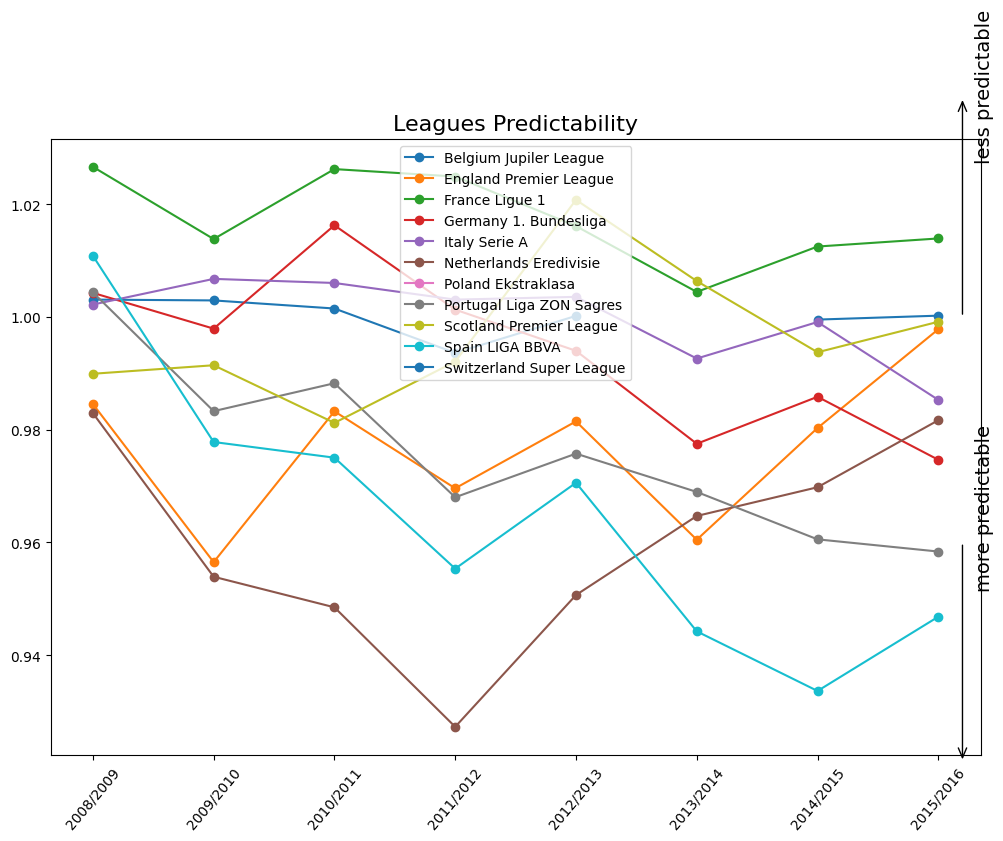

In [364]:
#plot graph
ax = entropy_means.plot(figsize=(12,8),marker='o')
plt.title('Leagues Predictability', fontsize=16)
plt.xticks(rotation=50) #set ticks roatation
colors = [x.get_color() for x in ax.get_lines()]
colors_mapping = dict(zip('league',colors)) #keep colors for next graph
ax.set_xlabel('') #remove x label
plt.legend(loc='upper center') #locate legend

#add arrows
ax.annotate('', xytext=(7.2, 1),xy=(7.2, 1.039),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.2, 0.96),xy=(7.2, 0.921),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(7.3, 1.028), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.3, 0.952), annotation_clip=False,fontsize=14,rotation='vertical')

* This information help us scale the data. So now we know that Spain League and Portugal Liga are the most predictable in this dataset.



---



* Below, we prepare data for modeling match results via the Pousson model. This model is heavy and does not work on the population gene - therefore it is important to scale the data to the desired relevant sample:

In [365]:
goal_model_data = pd.concat([
    matches[['home_team','away_team','home_goal']].assign(home=1).rename(columns={'home_team':'team', 'away_team':'opponent','home_goal':'goals'}),
    matches[['away_team','home_team','away_goal']].assign(home=0).rename(columns={'away_team':'team', 'home_team':'opponent','away_goal':'goals'})
])
goal_model_data

,team,opponent,goals,home
22,Oud-Heverlee Leuven,KV Mechelen,1,1
23,Oud-Heverlee Leuven,Club Brugge KV,3,1
24,Oud-Heverlee Leuven,Waasland-Beveren,5,1
25,Oud-Heverlee Leuven,KV Kortrijk,0,1
26,Oud-Heverlee Leuven,KV Oostende,4,1
...,...,...,...,...
6680,KAA Gent,Royal Excel Mouscron,3,0
6681,Sporting Lokeren,Royal Excel Mouscron,2,0
6682,Sint-Truidense VV,Royal Excel Mouscron,2,0
6683,SV Zulte-Waregem,Royal Excel Mouscron,1,0




---



* We can use the betting entropy data by league to model more substantive outcomes

In [366]:
poisson_model = smf.glm(formula="goals ~ home + team + opponent", 
                        data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                12062
Model:                            GLM   Df Residuals:                    11570
Model Family:                 Poisson   Df Model:                          491
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16929.
Date:                Thu, 11 May 2023   Deviance:                       12960.
Time:                        11:08:09   Pearson chi2:                 1.12e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.1714
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.1936      0.194      1.001      0.317      -0.186       0.573
team[T.1. FC Köln]                          -0.3350      0.193     -1.732      0.083      -0.714       0.044
team[T.1. FC Nürnberg]                      -0.2889      0.197     -1.467      0.142      -0.675       0.097
team[T.1. FSV Mainz 05]                     -0.1736      0.186     -0.934      0.350      -0.538       0.191
team[T.AC Ajaccio]                          -0.1929      0.171     -1.131      0.258      -0.527       0.141
team[T.AC Arles-Avignon]                    -0.7303      0.236     -3.088      0.002      -1.194      -0.267
team[T.ADO Den Haag]                         0.0250      0.155      0.162      0.871      -0.278       0.328
team[T.AJ Auxerre]                          -0.2422      0.166     -1.457      0.145      -0.568       0.084
team[T.AS Monaco]                           -0.0474      0.147     -0.323      0.747      -0.335       0.240
team[T.AS Nancy-Lorraine]                   -0.1746      0.157     -1.114      0.265      -0.482       0.133
team[T.AS Saint-Étienne]                    -0.1069      0.148     -0.723      0.470      -0.396       0.183
team[T.AZ]                                   0.3817      0.139      2.744      0.006       0.109       0.654
team[T.Aberdeen]                             0.0864      0.172      0.503      0.615      -0.250       0.423
team[T.Académica de Coimbra]                -0.3850      0.185     -2.084      0.037      -0.747      -0.023
team[T.Ajax]                                 0.5778      0.133      4.345      0.000       0.317       0.838
team[T.Angers SCO]                          -0.1256      0.185     -0.680      0.496      -0.487       0.236
team[T.Arsenal]                              0.4205      0.128      3.276      0.001       0.169       0.672
team[T.Aston Villa]                         -0.0170      0.143     -0.119      0.905      -0.297       0.263
team[T.Atalanta]                            -0.1330      0.152     -0.877      0.380      -0.430       0.164
team[T.Athletic Club de Bilbao]             -0.0572      0.146     -0.392      0.695      -0.343       0.229
team[T.Atlético Madrid]                      0.4248      0.130      3.279      0.001       0.171       0.679
team[T.Bari]                                -0.0392      0.167     -0.234      0.815      -0.367       0.289
team[T.Bayer 04 Leverkusen]                  0.2983      0.166      1.794      0.073      -0.028       0.624
team[T.Beerschot AC]                         0.0235      0.167      0.141      0.888      -0.303       0.350
team[T.Birmingham City]                     -0.2554      0.177     -1.444      0.149      -0.602       0.091
team[T.Blackburn Rovers]       



---



---



* Here we test the model on the data and simulate the results of a real match to compare the prediction with the real score

In [367]:
home_team='Manchester City'
away_team='Arsenal'
home_score_rate=poisson_model.predict(pd.DataFrame(data={'team': home_team, 'opponent': away_team, 'home':1},index=[1]))
away_score_rate=poisson_model.predict(pd.DataFrame(data={'team': away_team, 'opponent': home_team, 'home':0},index=[1]))

print(f'{home_team} against {away_team} expect to score: {round(home_score_rate.to_list()[0],2)}')
print(f'{away_team} against {home_team} expect to score: {round(away_score_rate.to_list()[0],2)}')

Manchester City against Arsenal expect to score: 1.59
Arsenal against Manchester City expect to score: 1.58


In [368]:
home_goals=np.random.poisson(home_score_rate)
away_goals=np.random.poisson(away_score_rate)

print(home_team + ': ' + str(home_goals[0]))
print(away_team + ': '  + str(away_goals[0]))

Manchester City: 0
Arsenal: 2


In [369]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 'opponent': awayTeam,'home':1}, index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 'opponent': homeTeam,'home':0}, index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

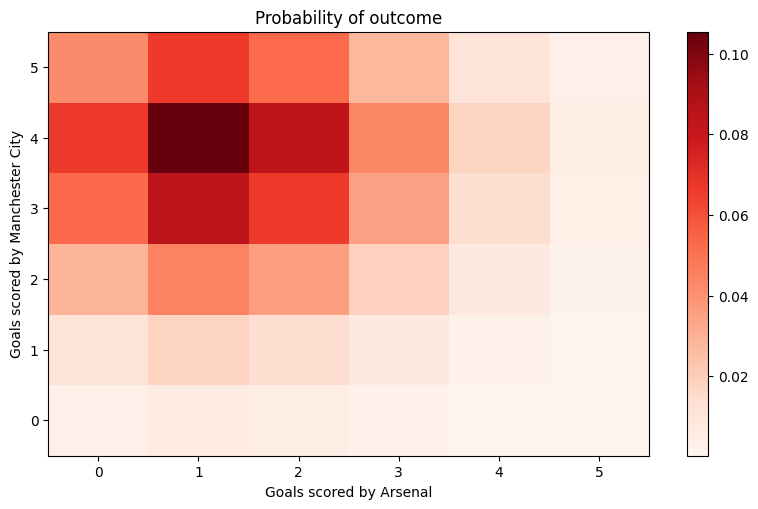

In [370]:
max_goals=5
score_matrix=simulate_match(poisson_model, home_team, away_team,max_goals)

fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(1,1,1)

pos=ax.imshow(score_matrix, extent=[-0.5,max_goals+0.5,-0.5,max_goals+0.5], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of outcome')
plt.xlim((-0.5,5.5))
plt.ylim((-0.5,5.5))
plt.tight_layout()
ax.set_xlabel('Goals scored by ' + away_team)
ax.set_ylabel('Goals scored by ' + home_team)
plt.show()

In [371]:
homewin=np.sum(np.tril(score_matrix, -1))
draw=np.sum(np.diag(score_matrix))
awaywin=np.sum(np.triu(score_matrix, 1))
print(f'Probabilities \n{home_team} win: {round(homewin,2)}, draw: {round(draw,2)}, {away_team} win: {round(awaywin,2)}') 

Probabilities 
Manchester City win: 0.38, draw: 0.24, Arsenal win: 0.37


   

---



* Below is the script for calculating statistics by team ID

In [372]:
def get_team_info(t_id) -> dict:
    # Firstly, create dict
    team_info = {'team_id':t_id}
    team_id = str(t_id)
    
    # Collecting all matches for team with given team_id 
    home_matches = pd.read_sql(f'SELECT * FROM Match WHERE home_team_api_id = {team_id}', conn)
    away_matches = pd.read_sql(f'SELECT * FROM Match WHERE away_team_api_id = {team_id}', conn)
    matches = pd.concat([home_matches, away_matches])
    matches = matches.reset_index(drop=True)
    
    # WIN/LOSE stats :
    team_info['home_wins'] = int(pd.read_sql(f'''
    SELECT count(home_team_api_id) as cnt
    FROM Match
    WHERE home_team_api_id = {team_id} and away_team_goal < home_team_goal
    ''', conn)['cnt'])
    
    team_info['home_draws'] = int(pd.read_sql(f'''
    SELECT count(home_team_api_id) as cnt
    FROM Match
    WHERE home_team_api_id = {team_id} and away_team_goal = home_team_goal
    ''', conn)['cnt'])
    
    team_info['home_loses'] = home_matches.shape[0] - team_info['home_draws'] - team_info['home_wins']
    
    team_info['away_wins'] = int(pd.read_sql(f'''
    SELECT count(away_team_api_id) as cnt
    FROM Match
    WHERE away_team_api_id = {team_id} and away_team_goal > home_team_goal
    ''', conn)['cnt'])
    
    team_info['away_draws'] = int(pd.read_sql(f'''
    SELECT count(away_team_api_id) as cnt
    FROM Match
    WHERE away_team_api_id = {team_id} and away_team_goal = home_team_goal
    ''', conn)['cnt'])
    
    team_info['away_loses'] = away_matches.shape[0] - team_info['away_draws'] - team_info['away_wins']
    
    return team_info
get_team_info(1773)

{'team_id': 1773,
 'home_wins': 16,
 'home_draws': 13,
 'home_loses': 16,
 'away_wins': 6,
 'away_draws': 15,
 'away_loses': 24}



---



* **Team stats research:**

In [373]:
matches_by_teams = allmatches.groupby(['home_team'])['home_team'].count().reset_index(name="games_played")
goals_scored_by_teams = allmatches.groupby(['home_team'])['home_goal'].sum().reset_index(name="goals_scored")
goals_lost_by_teams = allmatches.groupby(['home_team'])['away_goal'].sum().reset_index(name="goals_lost")
goals_by_teams = pd.merge(pd.merge(matches_by_teams,goals_scored_by_teams,on='home_team'),goals_lost_by_teams,on='home_team')
goals_by_teams['goals_scored_per_game'] = goals_by_teams['goals_scored']/goals_by_teams['games_played']
goals_by_teams['goals_lost_per_game'] = goals_by_teams['goals_lost']/goals_by_teams['games_played']
goals_by_teams['goal_scored/goal_lost ratio'] = goals_by_teams['goals_scored']/goals_by_teams['goals_lost']
goals_by_teams['goal_scored/goal_lost ratio'] = goals_by_teams['goals_scored']/goals_by_teams['goals_lost']
goals_by_teams.columns = goals_by_teams.columns.str.replace('home_team', 'team_name')
goals_by_teams = pd.merge(goals_by_teams,best_teams,on='team_name', how = 'left')
goals_by_teams

,team_name,games_played,goals_scored,goals_lost,goals_scored_per_game,goals_lost_per_game,goal_scored/goal_lost ratio,total_games,wins,win_percentage
0,1. FC Kaiserslautern,34,37,47,1.088235,1.382353,0.787234,68.0,17.0,25.0
1,1. FC Köln,102,116,139,1.137255,1.362745,0.834532,204.0,60.0,29.0
2,1. FC Nürnberg,85,108,118,1.270588,1.388235,0.915254,170.0,49.0,28.0
3,1. FSV Mainz 05,119,171,129,1.436975,1.084034,1.325581,238.0,88.0,36.0
4,AC Ajaccio,57,64,77,1.122807,1.350877,0.831169,114.0,22.0,19.0
...,...,...,...,...,...,...,...,...,...,...
280,Xerez Club Deportivo,19,20,29,1.052632,1.526316,0.689655,38.0,8.0,21.0
281,Zagłębie Lubin,89,114,108,1.280899,1.213483,1.055556,180.0,59.0,32.0
282,Zawisza Bydgoszcz,30,43,38,1.433333,1.266667,1.131579,60.0,19.0,31.0
283,Évian Thonon Gaillard FC,76,105,103,1.381579,1.355263,1.019417,152.0,45.0,29.0


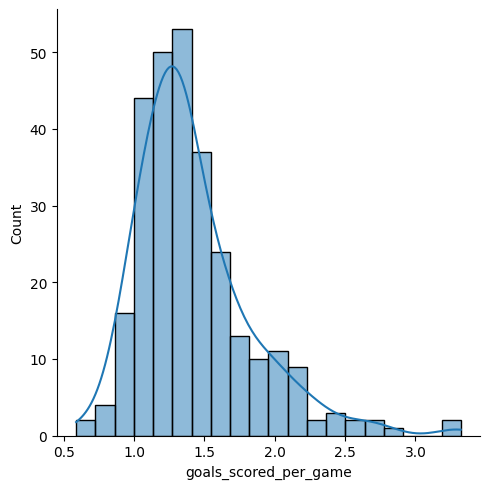

In [374]:
sns.displot(data=goals_by_teams,x='goals_scored_per_game', kde=True)

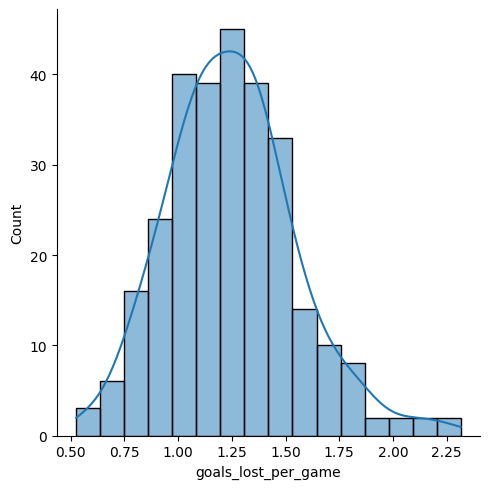

In [375]:
sns.displot(data=goals_by_teams,x='goals_lost_per_game', kde=True)

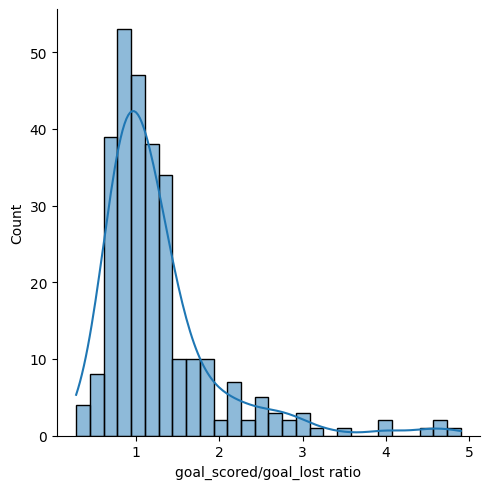

In [376]:
sns.displot(data=goals_by_teams,x='goal_scored/goal_lost ratio', kde=True)

In [377]:
allmatches.result.value_counts()

 1    11756
-1     7363
 0     6510
Name: result, dtype: int64

In [378]:
draw_games_by_teams = allmatches[allmatches['result']== 0]
draw_games_by_teams = draw_games_by_teams.groupby('home_team')['result'].count().reset_index(name = "draw_matches")
filter_lost_results = allmatches[allmatches['result']== -1]
lost_games_by_teams = filter_lost_results.groupby('home_team')['result'].count().reset_index(name = "losts")
draw_games_by_teams.columns = draw_games_by_teams.columns.str.replace('home_team', 'team_name')
lost_games_by_teams.columns = lost_games_by_teams.columns.str.replace('home_team', 'team_name')
result_by_teams = pd.merge(pd.merge(goals_by_teams,lost_games_by_teams,on='team_name'),draw_games_by_teams, on='team_name')

result_by_teams['lost_percentage'] = round(result_by_teams['losts']/result_by_teams['total_games']*100,1)
result_by_teams['draw_percentage'] = round(result_by_teams['draw_matches']/result_by_teams['total_games']*100,1)

result_by_teams

,team_name,games_played,goals_scored,goals_lost,goals_scored_per_game,goals_lost_per_game,goal_scored/goal_lost ratio,total_games,wins,win_percentage,losts,draw_matches,lost_percentage,draw_percentage
0,1. FC Kaiserslautern,34,37,47,1.088235,1.382353,0.787234,68.0,17.0,25.0,15,11,22.1,16.2
1,1. FC Köln,102,116,139,1.137255,1.362745,0.834532,204.0,60.0,29.0,39,31,19.1,15.2
2,1. FC Nürnberg,85,108,118,1.270588,1.388235,0.915254,170.0,49.0,28.0,34,21,20.0,12.4
3,1. FSV Mainz 05,119,171,129,1.436975,1.084034,1.325581,238.0,88.0,36.0,35,29,14.7,12.2
4,AC Ajaccio,57,64,77,1.122807,1.350877,0.831169,114.0,22.0,19.0,22,19,19.3,16.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,Xerez Club Deportivo,19,20,29,1.052632,1.526316,0.689655,38.0,8.0,21.0,9,4,23.7,10.5
280,Zagłębie Lubin,89,114,108,1.280899,1.213483,1.055556,180.0,59.0,32.0,28,27,15.6,15.0
281,Zawisza Bydgoszcz,30,43,38,1.433333,1.266667,1.131579,60.0,19.0,31.0,12,5,20.0,8.3
282,Évian Thonon Gaillard FC,76,105,103,1.381579,1.355263,1.019417,152.0,45.0,29.0,30,17,19.7,11.2


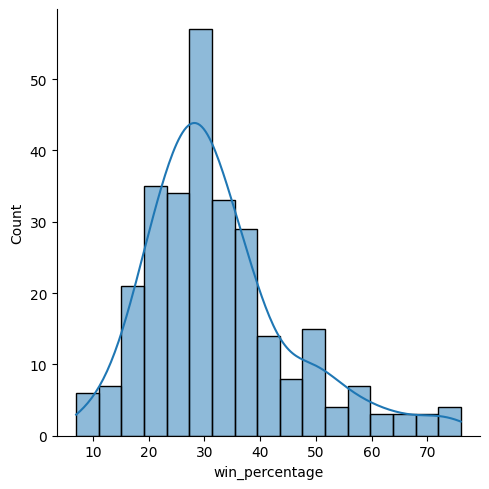

In [379]:
sns.displot(data=result_by_teams,x='win_percentage', kde=True)

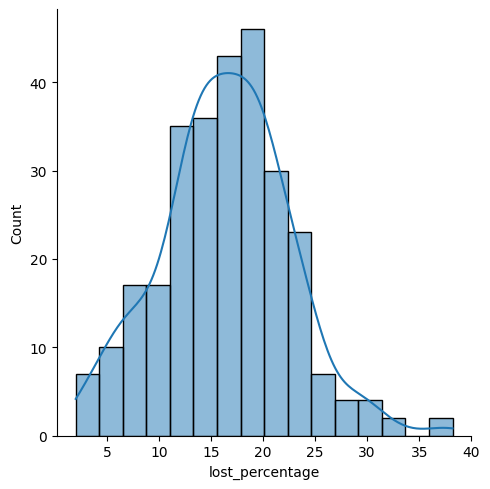

In [380]:
sns.displot(data=result_by_teams,x='lost_percentage', kde=True)

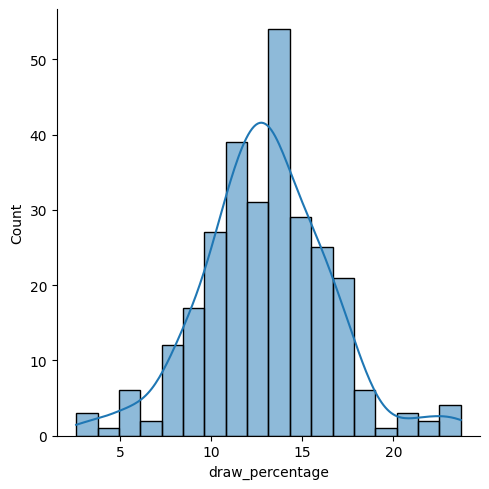

In [381]:
sns.displot(data=result_by_teams,x='draw_percentage', kde=True)



---



* **Connection of selected parameters of players by teams:**

In [382]:
def calc_score(team_attrib,allmatches1,unique_players):
    list_seasons = ['2008/2009',
                     '2009/2010',
                     '2010/2011',
                     '2011/2012',
                     '2012/2013',
                     '2013/2014',
                     '2014/2015',
                     '2015/2016']
    away = ["away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    home = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
                   "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
                   "home_player_11"]
    
    # dates for player stats cutoffs
    base = datetime.date(2008,6,1)
    date_list = [base + relativedelta(years=x) for x in range(9)]
    master_list = []
    list_attributes_off = []
    list_attributes_def = []
    count = 0
    for team_api_id in team_attrib['team_api_id']:
        count += 1
        # print("Team {}".format(count))
        for i, season in enumerate(list_seasons):
            games = allmatches1[((allmatches1['h_api_id'] == team_api_id) | (allmatches1['a_api_id'] == team_api_id)) & (allmatches1['season'] == season)]
            home_players = games[games['h_api_id'] == team_api_id][home].to_numpy().flatten() # players that played at home
            away_players = games[games['h_api_id'] == team_api_id][away].to_numpy().flatten()# players that played away
            all_players = np.unique(np.append(home_players,away_players)) # all unique player ids for team
            all_players = all_players[~np.isnan(all_players)] # dropna
            
            # offensive score ranking
            off_stats = unique_players[(unique_players['player_id'].isin(all_players)) & 
                    (unique_players.date.dt.date < date_list[i+1]) & 
                    (unique_players.date.dt.date > date_list[i])].groupby(
                ['player_name',"player_id"]).mean()
           
           # defensive score ranking
            def_stats = unique_players[(unique_players['player_id'].isin(all_players)) & 
                    (unique_players.date.dt.date < date_list[i+1]) & 
                    (unique_players.date.dt.date > date_list[i])].groupby(
                ['player_name',"player_id"]).mean()
            
            def_index = def_stats['defensive_score'].sort_values(ascending=False)[:5].mean() #sum of top 5 players averaged accross the season and attributes
            off_index = off_stats['offensive_score'].sort_values(ascending=False)[:5].mean()
            
            ls = [team_api_id, season, off_index, def_index]
            master_list.append(ls)
    scores = pd.DataFrame(master_list,columns=["team_api_id", "season", "off_index", "def_index"])
    
    return scores 
scores = calc_score(team_attrib,allmatches1,unique_players)

In [383]:
scores.dropna(inplace=True)

In [384]:
scores

,team_api_id,season,off_index,def_index
11,1773,2011/2012,61.922857,64.560000
12,1773,2012/2013,64.998250,68.796712
15,1773,2015/2016,71.051216,74.767914
25,2033,2009/2010,56.068000,62.788394
26,2033,2010/2011,66.902778,70.539762
...,...,...,...,...
2286,158085,2014/2015,66.229286,68.859190
2287,158085,2015/2016,73.281793,75.457831
2295,208931,2015/2016,77.381081,80.583070
2302,274581,2014/2015,60.579150,64.024304


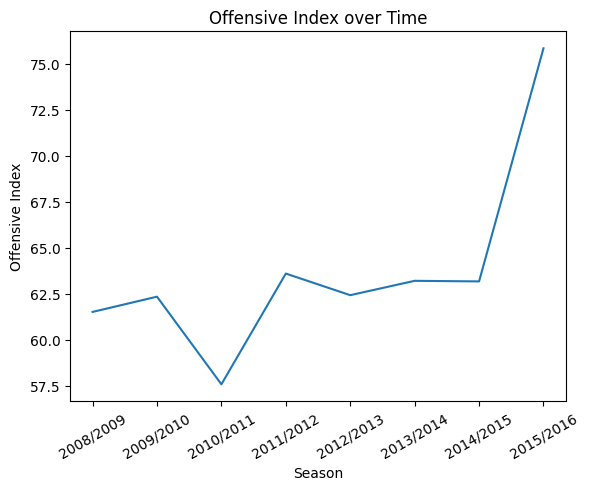

In [385]:
scores.groupby('season')['off_index'].mean().plot(rot=30)
plt.xlabel('Season')
plt.ylabel('Offensive Index')
plt.title('Offensive Index over Time')
plt.show()

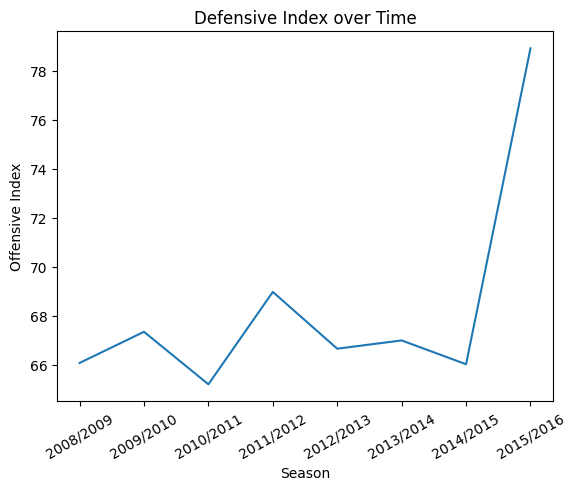

In [386]:
scores.groupby('season')['def_index'].mean().plot(rot=30)
plt.xlabel('Season')
plt.ylabel('Offensive Index')
plt.title('Defensive Index over Time')
plt.show()

Coefficients:  [0.74965581]
Intercept:  20.550822739151123


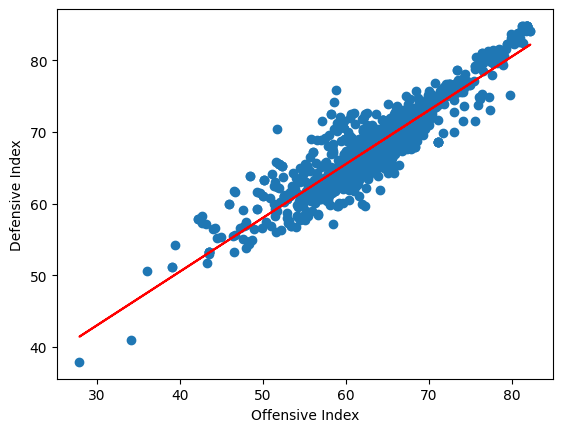

In [387]:
from sklearn.linear_model import LinearRegression
scores = scores.dropna()

X = scores[["off_index"]]
y = scores["def_index"]

model = LinearRegression()
model.fit(X, y)

print("Coefficients: ", model.coef_)
print("Intercept: ", model.intercept_)

y_pred = model.predict(X)

plt.scatter(X, y)
plt.plot(X, y_pred, color="red")
plt.xlabel("Offensive Index")
plt.ylabel("Defensive Index")
plt.show()

In [388]:
# creating a DataFrame for scores group by team_api_id
scores_team=pd.DataFrame({'off_index' : scores.groupby('team_api_id')['off_index'].mean(), 'def_index' : scores.groupby('team_api_id')['def_index'].mean() }).reset_index()
scores_team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   team_api_id  248 non-null    int64  
 1   off_index    248 non-null    float64
 2   def_index    248 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 5.9 KB


In [389]:
merged_data=scores_team.merge(team_points, how='left', on='team_api_id')
merged_data=merged_data.merge(result_by_teams, how='left', on='team_name')
merged_data['total_points'] = merged_data['home_Points'] + merged_data['away_Points']
merged_data['normalized_points'] = merged_data['total_points']/merged_data['games_played']
merged_data.dropna(inplace=True)
merged_data.normalized_points.describe()

count    246.000000
mean       2.756837
std        0.083516
min        2.526316
25%        2.705882
50%        2.750000
75%        2.797563
max        3.025424
Name: normalized_points, dtype: float64

In [390]:
merged_data.corr()

,team_api_id,off_index,def_index,home_Points,away_Points,games_played,goals_scored,goals_lost,goals_scored_per_game,goals_lost_per_game,goal_scored/goal_lost ratio,total_games,wins,win_percentage,losts,draw_matches,lost_percentage,draw_percentage,total_points,normalized_points
team_api_id,1.000000,0.109540,0.132158,-0.103835,-0.107211,-0.122111,-0.102390,-0.122995,-0.079115,0.037637,-0.059837,-0.121319,-0.095243,-0.081330,-0.096329,-0.120233,0.089822,-0.011430,-0.119962,0.032406
off_index,0.109540,1.000000,0.950062,-0.001984,-0.037416,-0.017584,0.002755,-0.011388,0.032693,-0.110214,0.025511,-0.017329,-0.002749,0.073282,-0.035411,-0.032290,-0.084777,0.029927,-0.015560,-0.036222
def_index,0.132158,0.950062,1.000000,0.016900,-0.031955,0.000388,0.025555,0.000743,0.047000,-0.131900,0.044127,-0.000976,0.015276,0.081208,-0.032036,-0.018818,-0.109957,0.047751,0.000991,-0.075386
home_Points,-0.103835,-0.001984,0.016900,1.000000,0.467694,0.931653,0.980565,0.702055,0.791332,-0.706881,0.780645,0.932559,0.984639,0.851500,0.369377,0.682741,-0.828572,-0.369441,0.943423,0.309383
away_Points,-0.107211,-0.037416,-0.031955,0.467694,1.000000,0.754221,0.416297,0.913787,-0.002563,-0.147630,-0.077260,0.753516,0.362262,0.067367,0.985208,0.844923,-0.149637,0.072250,0.734324,-0.077696
games_played,-0.122111,-0.017584,0.000388,0.931653,0.754221,1.000000,0.895053,0.892007,0.580146,-0.588777,0.542851,0.999590,0.875346,0.652964,0.670707,0.866677,-0.681903,-0.216172,0.998426,0.161850
goals_scored,-0.102390,0.002755,0.025555,0.980565,0.416297,0.895053,1.000000,0.688043,0.858292,-0.643077,0.808790,0.894767,0.980132,0.860910,0.327829,0.613332,-0.804489,-0.408018,0.909216,0.323932
goals_lost,-0.122995,-0.011388,0.000743,0.702055,0.913787,0.892007,0.688043,1.000000,0.339825,-0.239623,0.189929,0.890937,0.614801,0.342434,0.874874,0.854335,-0.390022,-0.098308,0.881962,0.052664
goals_scored_per_game,-0.079115,0.032693,0.047000,0.791332,-0.002563,0.580146,0.858292,0.339825,1.000000,-0.560433,0.904101,0.581141,0.840962,0.908713,-0.075044,0.227783,-0.808192,-0.504740,0.606756,0.420412
goals_lost_per_game,0.037637,-0.110214,-0.131900,-0.706881,-0.147630,-0.588777,-0.643077,-0.239623,-0.560433,1.000000,-0.747139,-0.591154,-0.712588,-0.759069,-0.047084,-0.432090,0.841005,0.171520,-0.598245,-0.179588


here is time to try prediction models



---



---



In [391]:
stat_per_season=allmatches[['league', 'season','home_team','h_api_id','home_Points','away_Points','goal_dif','entropy']]
stat_per_season=k.groupby(['season','league', 'home_team','h_api_id']).agg({'home_Points': 'sum', 'away_Points': 'sum', 'goal_dif': 'mean', 'entropy': 'mean'}).reset_index()
stat_per_season.rename(columns = {'h_api_id ':' team_api_id'}, inplace = True )
stat_per_season.head(3)

,season,league,home_team,h_api_id,home_Points,away_Points,goal_dif,entropy
0,2008/2009,Belgium Jupiler League,Beerschot AC,9993,26,17,0.733333,1.052082
1,2008/2009,Belgium Jupiler League,Club Brugge KV,8342,31,13,0.800000,0.925906
2,2008/2009,Belgium Jupiler League,KAA Gent,9991,26,17,0.933333,0.966139


In [392]:
results = smf.ols('normalized_points ~ off_index + def_index + def_index*off_index', data=merged_data).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      normalized_points   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.848
Date:                Thu, 11 May 2023   Prob (F-statistic):              0.139
Time:                        11:09:06   Log-Likelihood:                 264.98
No. Observations:                 246   AIC:                            -522.0
Df Residuals:                     242   BIC:                            -507.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.6265    

In [401]:
datacl = merged_data.copy()
datacl.columns
# define a function y parameter
def this_map(x):
    if x > 2.6:
        return 1
    return 0
datacl['champion'] = datacl['normalized_points'].apply(lambda x:this_map(x))


In [402]:
rf = RandomForestClassifier()
lr = LogisticRegression()
xgb = XGBClassifier()

In [403]:
encoder = OneHotEncoder()

# Fit the encoder to the data and transform the data
encoded_data = encoder.fit_transform(datacl[['off_index', 'def_index','team_name']])

In [404]:
encoded_data = pd.get_dummies(datacl[['off_index', 'def_index','team_name']], columns=['team_name'])
encoded_data

,off_index,def_index,team_name_1. FC Kaiserslautern,team_name_1. FC Köln,team_name_1. FC Nürnberg,team_name_1. FSV Mainz 05,team_name_AC Ajaccio,team_name_AC Arles-Avignon,team_name_ADO Den Haag,team_name_AJ Auxerre,...,team_name_Vitória Guimarães,team_name_Vitória Setúbal,team_name_Waasland-Beveren,team_name_Watford,team_name_West Bromwich Albion,team_name_West Ham United,team_name_Wigan Athletic,team_name_Willem II,team_name_Wolverhampton Wanderers,team_name_Évian Thonon Gaillard FC
0,65.990774,69.374875,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,64.831085,68.334574,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,61.982739,65.775712,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,63.779000,69.543394,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,48.001905,53.846952,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,45.008333,55.300000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,64.022366,68.193769,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
244,54.942619,64.360667,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
245,68.529304,71.119948,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [405]:
X = datacl[['off_index', 'def_index']]
X = encoded_data
y = datacl['champion']

In [406]:
rf.fit(X,y)
xgb.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [407]:
lr.fit(X,y)

LogisticRegression()

In [408]:
#respective class counts
num_positive = y.value_counts()[1]
num_negative = y.value_counts()[0]

In [409]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

#Use Randomized Search 5 fold Cross Validation 
#Find optimal hyperparameters for XGBoost
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), 
    "max_depth": randint(2, 6), 
    "n_estimators": randint(100, 150), 
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb, param_distributions=params, 
random_state=42, cv=8, n_jobs=8,scoring='roc_auc')

search.fit(X, y)

RandomizedSearchCV(cv=8,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f4c079b9930>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4c079ba890>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4c21635780>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f4c05d0a530>},
                   random_state=42, scoring='roc_auc')

In [410]:
print("Best AUC:", search.best_score_)

Best AUC: nan


In [411]:
xgb_best = XGBClassifier(use_label_encoder=False,eval_metric='auc',scale_pos_weight=num_negative/num_positive, **search.best_params_)
xgb_best.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8123620356542087, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.4753571532049581, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.24959818254342153, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=120, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [412]:
cross_val_score(xgb_best,X,y,cv=10,scoring='accuracy').mean()

0.7725

In [413]:
cross_val_score(xgb_best,X,y,cv=10,scoring='roc_auc').mean()

nan

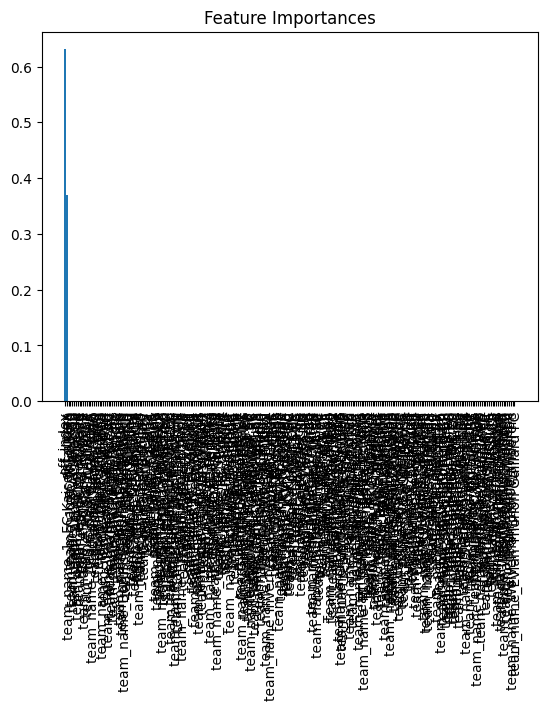

In [414]:
importance_scores = xgb_best.feature_importances_
# Plot the feature importances
# Plot the feature importances
plt.bar(range(len(importance_scores)), importance_scores, tick_label=X.columns)
plt.xticks(rotation=90)
plt.title('Feature Importances')
plt.show()

Random Forest Feature Importance Ranking:
1. def_index (0.159026)
2. off_index (0.127913)
3. team_name_Reading (0.112186)
4. team_name_DSC Arminia Bielefeld (0.107080)
5. team_name_Angers SCO (0.104862)
6. team_name_Birmingham City (0.103381)
7. team_name_Lierse SK (0.096771)
8. team_name_Reggio Calabria (0.092872)
9. team_name_Novara (0.069324)
10. team_name_FC St. Pauli (0.002619)
11. team_name_UD Las Palmas (0.001996)
12. team_name_GFC Ajaccio (0.001894)
13. team_name_St. Johnstone FC (0.001389)
14. team_name_Hércules Club de Fútbol (0.001238)
15. team_name_Eintracht Braunschweig (0.001216)
16. team_name_Portsmouth (0.001123)
17. team_name_Valenciennes FC (0.001004)
18. team_name_Newcastle United (0.000896)
19. team_name_Stade Brestois 29 (0.000812)
20. team_name_Blackpool (0.000783)
21. team_name_Frosinone (0.000773)
22. team_name_Bournemouth (0.000598)
23. team_name_Watford (0.000588)
24. team_name_Manchester City (0.000505)
25. team_name_Borussia Mönchengladbach (0.000343)
26. te

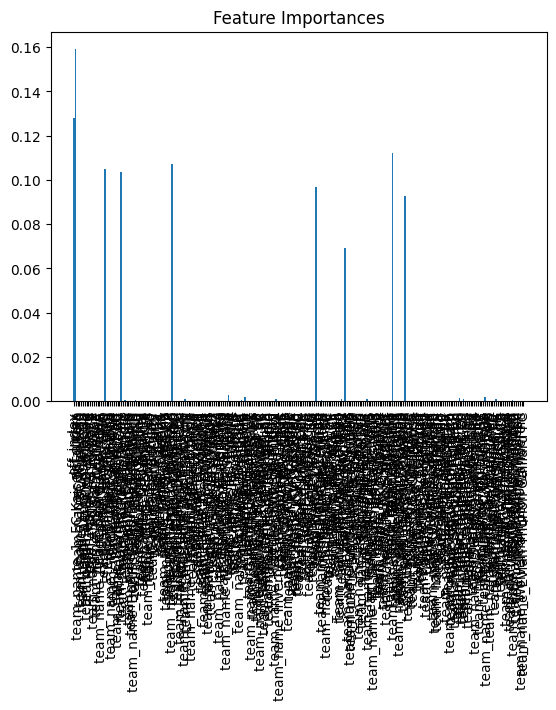

In [415]:
importances = rf.feature_importances_

# Sort the importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Random Forest Feature Importance Ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))
    
plt.bar(range(len(importances)), importances, tick_label=X.columns)
plt.xticks(rotation=90)
plt.title('Feature Importances')
plt.show()

In [416]:
cross_val_score(xgb,X,y,cv=10,scoring='roc_auc').mean()

nan

In [417]:
cross_val_score(xgb,X,y,cv=10,scoring='accuracy').mean()

0.9718333333333333

In [418]:
cross_val_score(rf,X,y,cv=10,scoring='roc_auc').mean()

nan

In [419]:
cross_val_score(rf,X,y,cv=10,scoring='accuracy').mean()

0.9718333333333333

In [420]:
cross_val_score(lr,X,y,cv=10,scoring='accuracy').mean()

0.9718333333333333

In [421]:
cross_val_score(lr,X,y,cv=10,scoring='roc_auc').mean()

nan

In [422]:
lr.coef_

array([[ 0.14058491, -0.11333022,  0.03212607,  0.02660196,  0.02539194,
         0.02347081,  0.02426776,  0.05421749,  0.02165389,  0.02996784,
         0.02256741,  0.04736612,  0.02965909,  0.0273017 ,  0.02855629,
         0.02517014,  0.02864501, -0.95860327,  0.03728299,  0.0272483 ,
         0.02054513,  0.02165677,  0.02510283,  0.03717673,  0.02672442,
         0.02305906, -0.90343785,  0.04373346,  0.07418799,  0.02189333,
         0.02316634,  0.04315804,  0.02434923,  0.02439434,  0.01335403,
         0.06618763,  0.03530693,  0.02382527,  0.02446233,  0.02082263,
         0.0683247 ,  0.02237074,  0.02259434,  0.02725389,  0.03072371,
         0.01556984,  0.02157452,  0.02806091,  0.02929414,  0.04081377,
         0.02729519,  0.02329964,  0.03142115,  0.0189257 , -0.89844482,
         0.0277705 ,  0.05110576,  0.02352451,  0.02653741,  0.02556909,
         0.02082931,  0.01754755,  0.02928905,  0.01940147,  0.01877823,
         0.01983217,  0.01994302,  0.03384206,  0.0

In [423]:
y_pred = cross_val_predict(xgb,X,y,cv=10)

# Generate a confusion matrix for the predicted labels and the true labels
cm = confusion_matrix(y, y_pred)

# Print the confusion matrix
print(cm)

[[  0   7]
 [  0 239]]


In [424]:
y_pred = cross_val_predict(rf,X,y,cv=10)

# Generate a confusion matrix for the predicted labels and the true labels
cm = confusion_matrix(y, y_pred)

# Print the confusion matrix
print(cm)

[[  0   7]
 [  0 239]]


In [425]:
pd.concat([X,y],axis=1)

,off_index,def_index,team_name_1. FC Kaiserslautern,team_name_1. FC Köln,team_name_1. FC Nürnberg,team_name_1. FSV Mainz 05,team_name_AC Ajaccio,team_name_AC Arles-Avignon,team_name_ADO Den Haag,team_name_AJ Auxerre,...,team_name_Vitória Setúbal,team_name_Waasland-Beveren,team_name_Watford,team_name_West Bromwich Albion,team_name_West Ham United,team_name_Wigan Athletic,team_name_Willem II,team_name_Wolverhampton Wanderers,team_name_Évian Thonon Gaillard FC,champion
0,65.990774,69.374875,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,64.831085,68.334574,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,61.982739,65.775712,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,63.779000,69.543394,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,48.001905,53.846952,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,45.008333,55.300000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
243,64.022366,68.193769,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
244,54.942619,64.360667,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
245,68.529304,71.119948,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
